In [1]:
import numpy as np
import spharpy
import matplotlib.pyplot as plt
import spharpy.beamforming

In [2]:
def plot_beampattern_azimuth(beampattern, angle, label='Beampattern'):
    plt.plot(angle, 20*np.log10(np.abs(beampattern)), label=label)
    plt.grid(True)
    ax = plt.gca()
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$',  '$3\pi/2$',  '$2\pi$'])
    ax.set_ylim((-60, 5))
    ax.set_ylabel('Magnitude [dB re 1]')
    ax.set_xlabel('Azimuth [$^\circ$]')
    plt.legend()

# Analytic Plane Wave

In [3]:
N = 7
doa = spharpy.samplings.Coordinates(-1,0,0)
p_nm = spharpy.spherical.spherical_harmonic_basis_real(N, doa)

# Beamforming

In [4]:
n_dirs = 1024
azi = np.linspace(0, 2*np.pi, n_dirs)
steering_directions = spharpy.samplings.Coordinates.from_spherical(np.ones(n_dirs), np.ones(n_dirs)*np.pi/2, azi)
Y_steering = spharpy.spherical.spherical_harmonic_basis_real(N, steering_directions)

## Plane Wave Decomposition

In [5]:
c_nm = 4*np.pi / (N+1)**2

In [6]:
plane_wave_dencomposition = c_nm * np.squeeze((Y_steering @ p_nm.T))

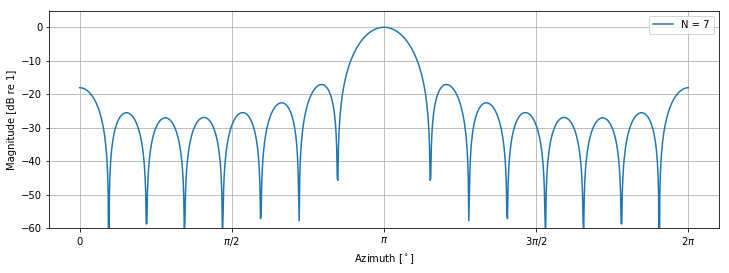

In [7]:
plt.figure(figsize=(12, 4))
plot_beampattern_azimuth(plane_wave_dencomposition, azi, label='N = {}'.format(N))

## Dolph Chebyshev Beamformer

The Dolph-Chebyshev design process consists of either choosing a desired side-lobe attenuation $R$ or main-lobe width $\theta_0$. 

In [8]:
R_dB = 50
R = 10**(R_dB/20)
d_nm_sidelobe = spharpy.beamforming.dolph_chebyshev_weights(N, R, design_criterion='sidelobe')
theta0 = np.pi/6
d_nm_mainlobe = spharpy.beamforming.dolph_chebyshev_weights(N, theta0, design_criterion='mainlobe')

In [9]:
dolph_cheby_sidelobe = np.squeeze(np.real(Y_steering @ np.diag(d_nm_sidelobe) @ p_nm.T))
dolph_cheby_mainlobe = np.squeeze(np.real(Y_steering @ np.diag(d_nm_mainlobe) @ p_nm.T))

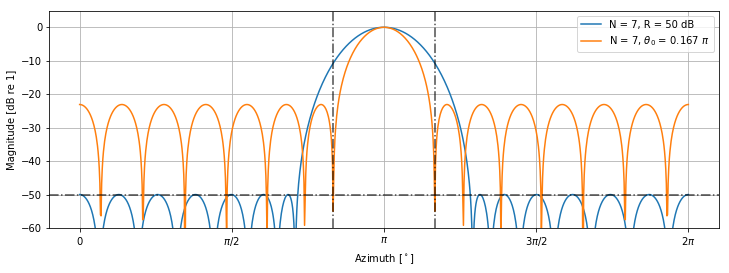

In [10]:
plt.figure(figsize=(12, 4))
plot_beampattern_azimuth(dolph_cheby_sidelobe, azi, label='N = {}, R = {} dB'.format(N, R_dB))
plot_beampattern_azimuth(dolph_cheby_mainlobe, azi, label='N = {}, $\\theta_0$ = {} $\\pi$'.format(N, np.round(theta0/np.pi, decimals=3)))
plt.axhline(-R_dB, color='k', linestyle='-.', alpha=0.7)
plt.axvline(theta0+doa.azimuth, color='k', linestyle='-.', alpha=0.7)
plt.axvline(doa.azimuth-theta0, color='k', linestyle='-.', alpha=0.7)

## rE max Weights

In [11]:
g_nm = spharpy.beamforming.rE_max_weights(N)
re_max = np.squeeze(Y_steering @ np.diag(g_nm) @ p_nm.T)

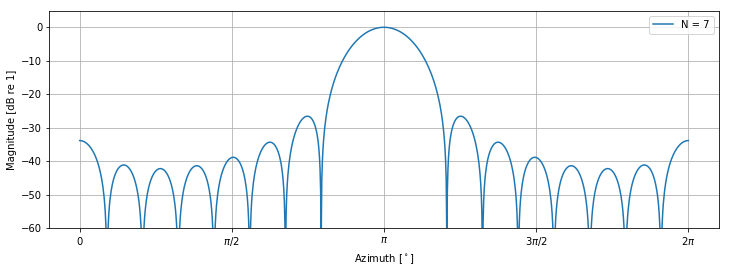

In [12]:
plt.figure(figsize=(12, 4))
plot_beampattern_azimuth(re_max/re_max.max(), azi, label='N = {}'.format(N))

## Hanning Window Weighting

In [13]:
from scipy.signal.windows import hann

In [14]:
h_n = hann(2*(N+1)+1)[N+1:-1]
h_nm = spharpy.indexing.sph_identity_matrix(N).T @ h_n
hanning = np.squeeze(Y_steering @ np.diag(h_nm) @ p_nm.T)

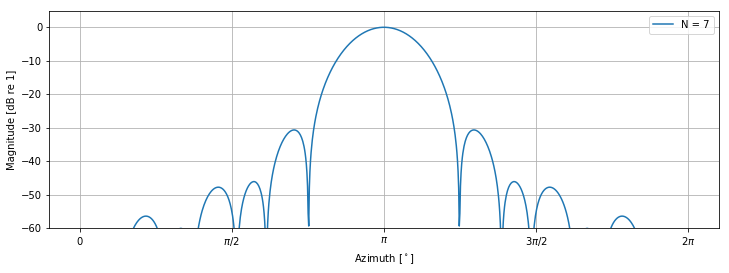

In [15]:
plt.figure(figsize=(12, 4))
plot_beampattern_azimuth(hanning/hanning.max(), azi, label='N = {}'.format(N))

## Maximum Front-Back Ratio

In [16]:
f_nm = spharpy.beamforming.maximum_front_back_ratio_weights(N)

In [17]:
max_fb = np.squeeze(Y_steering @ np.diag(f_nm) @ p_nm.T)

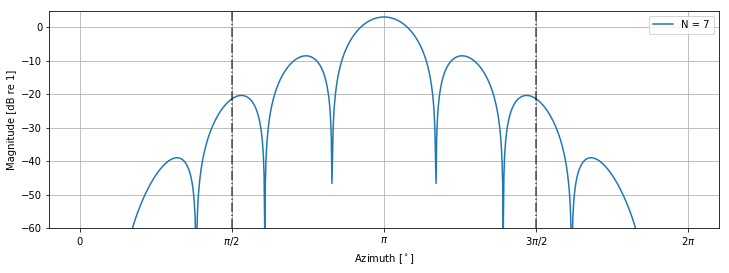

In [18]:
plt.figure(figsize=(12, 4))
plot_beampattern_azimuth(max_fb, azi, label='N = {}'.format(N))
plt.axvline(doa.azimuth+np.pi/2, color='k', linestyle='-.', alpha=0.7)
plt.axvline(doa.azimuth-np.pi/2, color='k', linestyle='-.', alpha=0.7)